In [39]:
%%bash
mkdir -p ~/SageMaker/frozen-lake
curl https://s3.amazonaws.com/sagemaker-us-east-1-537534971119/frozen-lake.tar.gz > frozen-lake.tar.gz
tar xvzf frozen-lake.tar.gz -C ~/SageMaker/frozen-lake/


frozen_lake/
frozen_lake/__init__.py
frozen_lake/config.py
frozen_lake/environment.py
frozen_lake/evaluate.py
frozen_lake/memory.py
frozen_lake/model.py
frozen_lake/state.py
frozen_lake/train.py
frozen_lake/utils.py
main.py
requirements.txt
setup.py


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4223  100  4223    0     0  11231      0 --:--:-- --:--:-- --:--:-- 11201


In [ ]:
!pip install -e ~/SageMaker/frozen-lake


In [78]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import torch
from gym.envs.toy_text.frozen_lake import FrozenLakeEnv

from sagemaker import get_execution_role
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import (
    HyperparameterTuner,
    ContinuousParameter,
    IntegerParameter,
)

from frozen_lake import (
    Level, LeveledFrozenLake,
    play_level, train, DeepQConfig,
    get_state, DeepQNetwork, moving_average,
    play_manually, get_test_level
)


In [79]:
# 初始化env,  gameBoard: Start Frozen Hole Goal
env = FrozenLakeEnv()
env.render()



SFFF
FHFH
FFFH
HFFG


In [80]:
# 打印 current state
>>> env.s

0

In [81]:

env = FrozenLakeEnv(is_slippery=False)
env.render()



SFFF
FHFH
FFFH
HFFG


In [82]:
#进入H或G游戏结束
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

env.step(DOWN)
env.render()


  (Down)
SFFF
FHFH
FFFH
HFFG


In [83]:
env.step(DOWN)
env.render()

  (Down)
SFFF
FHFH
FFFH
HFFG


In [84]:
env.step(RIGHT)
env.step(RIGHT)
env.step(DOWN)
env.render()

  (Down)
SFFF
FHFH
FFFH
HFFG


In [85]:
env.step(RIGHT)
env.render()

  (Right)
SFFF
FHFH
FFFH
HFFG


In [86]:
env.step(LEFT)
env.render()

  (Left)
SFFF
FHFH
FFFH
HFFG


In [87]:
ent.reset()

NameError: name 'ent' is not defined

In [88]:
env.reset()

0

In [89]:
# slipper分别开和关，进行游戏
# 手动模式体验游戏
env = FrozenLakeEnv(is_slippery=False)
play_manually(env)


  (Right)
SFFF
FHFH
FFFH
HFFG


-- Lose --


In [90]:
env.reset()
play_manually(env)

  (Right)
SFFF
FHFH
FFFH
HFFG


-- Win --


In [91]:
# 打开slipper体验游戏，冰面会很滑导致方向随机， 三选一。
env = FrozenLakeEnv(is_slippery=True)
play_manually(env)


  (Right)
SFFF
FHFH
FFFH
HFFG


In [92]:
env.reset()
play_manually(env)


SFFF
FHFH
FFFH
HFFG


In [17]:
env.reset()
play_manually(env)


SFFF
FHFH
FFFH
HFFG


In [93]:
# slipper太复杂，non-slipper太无聊。改变难度需要创建关卡，也就是不同的board。
# 为了创建不同的level, 先从调整出错概率开始
# LeveledFrozenLake是FrozenLake的子类， frozen_lake/environment.py
# random生成随机board数据并且设置mistake概率
random_level = LeveledFrozenLake.random(0.2)
print(random_level)
play_manually(random_level)

#可以多玩几次，关卡每次都不一样，0.2的mistake比slipper简单（67%的mistake）


  (Right)
SFFF
HFFF
HFFF
FFFG


In [94]:
# 可以调整mistake体验不同难度
random_level = LeveledFrozenLake.random(0.9)
play_manually(random_level)

  (Down)
SHFF
FFFF
FFFF
FFFG


-- Lose --


In [95]:
env.reset()

0

In [21]:
random_level = LeveledFrozenLake.random(0.2)
play_manually(random_level)


SFFF
FFFF
HHFF
FHFG


In [96]:
#创建random agent当作baseline
def random_action(env: FrozenLakeEnv) -> int:
    """Choose a random action"""
    action=np.random.randint(env.nA)
    return action


In [97]:
# frozen_lake/evaluate.py, 内部会调用100次random_action或game结束
# get_test_level() frozen_lake/environment.py, 使用mistake概率0.2生成board
# 返回reward结果 0.0 or 1.0
play_level(get_test_level(), random_action)


0.0

In [98]:
# 随机agent都运行在相同的level,跑10,000次
np.random.seed(1)
n_attempts = 10000
test_level = get_test_level()
rewards = [
    play_level(test_level, random_action)
    for _ in range(n_attempts)
]


In [99]:
sum(rewards) / n_attempts


0.0142

In [100]:
test_level = get_test_level()
test_level.render()
get_state(test_level)



SFFF
FHFH
FFFH
HFFG


tensor([0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0.])

In [101]:
config = DeepQConfig()


In [102]:
local_policy, reward = train(config)


MaxReward=0.63


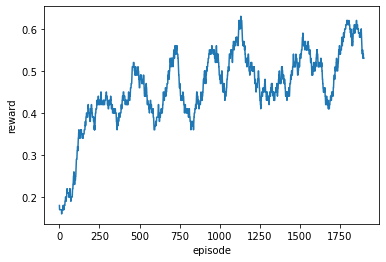

In [103]:
#查看training过程中moving average的reward
# reward不太稳定，所以下一步需要使用更多的hyperparameter去实验。
plt.plot(moving_average(reward))
plt.ylabel('reward')
plt.xlabel('episode');


In [104]:
# 使用得到的policy network进行测试，结果要比random agent好不少
np.random.seed(1)
n_attempts = 10000
test_level = get_test_level()
rewards = [
    play_level(test_level, local_policy.learned_action)
    for _ in range(n_attempts)
]
sum(rewards) / n_attempts


0.0687

In [105]:
# 因为之前的policy不太稳定，还不像个真人。所以可以尝试用不同的超参数去training。 SageMaker就会很方便
# frozen_lake/main.py requirements.txt source_dir
estimator = PyTorch('main.py',
                    source_dir='/home/ec2-user/SageMaker/frozen-lake/',
                    instance_type='ml.m5.large',
                    instance_count=1,
                    framework_version='1.2.0',
                    py_version='py3',
                    role = get_execution_role()
)


In [106]:
estimator.fit()


2021-04-25 04:46:48 Starting - Starting the training job...
2021-04-25 04:47:11 Starting - Launching requested ML instancesProfilerReport-1619326008: InProgress
......
2021-04-25 04:48:12 Starting - Preparing the instances for training......
2021-04-25 04:49:12 Downloading - Downloading input data...
2021-04-25 04:49:32 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-04-25 04:49:54,157 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2021-04-25 04:49:54,160 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-04-25 04:49:54,170 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-04-25 04:49:54,172 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-04-25 04:49:54,468 sagemaker-containers INFO     Installing module with the following command:


2021-04-25 04:50:12 Training - Training image download completed. Training in progress.MaxReward=0.63
2021-04-25 04:50:19,712 sagemaker-containers INFO     Reporting training SUCCESS

2021-04-25 04:50:32 Uploading - Uploading generated training model
2021-04-25 04:50:32 Completed - Training job completed
Training seconds: 84
Billable seconds: 84


In [111]:
# download到本地
!aws s3 cp $estimator.model_data ./
!tar xvzf model.tar.gz
!rm model.tar.gz


download: s3://sagemaker-us-west-2-417024059460/pytorch-training-2021-04-25-04-46-47-754/output/model.tar.gz to ./model.tar.gz
policy.pth
reward.npz


In [107]:
# 加载模型到内存
sagemaker_policy = DeepQNetwork(config.n_state_features, config.n_actions)
sagemaker_policy.load_state_dict(torch.load('policy.pth'))


<All keys matched successfully>

In [49]:
# 评估下性能，应该和刚才本地训练的模型效果一致，因为所有配置参数都一样
np.random.seed(1)
n_attempts = 10000
test_level = get_test_level()
rewards = [
    play_level(test_level, sagemaker_policy.learned_action)
    for _ in range(n_attempts)
]
sum(rewards) / n_attempts


0.0687

In [50]:
# 使用不同的config，HyperparameterTunner
# metric_definictions 代表metric和相应regex. hyperparameter_range指定超参数范围
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name='MaxReward',
    metric_definitions=[
        dict(
            Name='MaxReward',
            Regex='MaxReward=([0-9\\.]+)',
        )
    ],
    hyperparameter_ranges=dict(
        target_update=IntegerParameter(10, 500),
        epsilon_start=ContinuousParameter(0.25, 0.75),
    ),
    max_jobs=20,
    max_parallel_jobs=5,
)


In [ ]:
tuner.fit()
tuner.wait()


.....................................................................................................................................

In [52]:
# 下载最好的model
model_path = (
    estimator.output_path +
    tuner.best_training_job() +
    '/output/model.tar.gz'
)

!aws s3 cp $model_path ./
!tar xvzf model.tar.gz
!rm model.tar.gz


download: s3://sagemaker-us-west-2-417024059460/pytorch-training-210421-1551-014-7ebaee5f/output/model.tar.gz to ./model.tar.gz
policy.pth
reward.npz


In [53]:
# 加载到内存并评估
# agent效果应该已经足够用于模拟人了，比之前本地训练的提高很多
tuned_policy = DeepQNetwork(config.n_state_features, config.n_actions)
tuned_policy.load_state_dict(torch.load('policy.pth'))

n_attempts = 10000
rewards = [
    play_level(test_level, tuned_policy.learned_action)
    for _ in range(n_attempts)
]
sum(rewards) / n_attempts


0.2333

In [108]:
# 3. 现在开始自动玩游戏，评估关卡难度

# 创建10个level,每个level跑10,000次 
np.random.seed(1)
levels = []
for i in range(10):
    print(i)
    level_config = Level.random(config.p_mistake_draw)
    level = LeveledFrozenLake(level_config)
    win_precentage = sum(
        play_level(level, tuned_policy.learned_action) # play_level:frozen_lake/evaluate.py
        for _ in range(n_attempts)
    ) / n_attempts
    n_holes = (np.array(list(''.join(level_config.board))) == 'H').sum()
    levels.append(dict(
        difficulty=1-win_precentage,
        p_mistake=level_config.p_mistake,
        n_holes=n_holes,
        level=level,
    ))

levels = sorted(levels, key=lambda l: l['difficulty'])


0
1
2
3
4
5
6
7
8
9


In [55]:
# 按照难度排序输出level数据
level_df = pd.DataFrame(levels)
level_df = level_df.sort_values('difficulty')
level_df[['difficulty', 'p_mistake', 'n_holes']]


,difficulty,p_mistake,n_holes
0,0.0000,0.004590,0
1,0.0476,0.041576,3
2,0.0627,0.107153,2
3,0.0698,0.166809,1
4,0.0866,0.025981,2
5,0.6874,0.207159,2
6,0.7309,0.391397,2
7,0.9302,0.385349,3
8,0.9307,0.012158,3
9,0.9969,0.304502,5


In [109]:
# 手动去玩一下这些level，确认难度
easiest = 0
hardest = 9

play_manually(level_df.level[hardest])


  (Down)
SHHF
FFFH
HHFF
FFFG


-- Lose --


In [110]:
play_manually(level_df.level[hardest])


SHHF
FFFH
HHFF
FFFG


In [50]:
easiest = 0
hardest = 9

play_manually(level_df.level[1])



  (Down)
SFFF
FFFF
HHFF
FHFG


-- Win --


In [ ]:
# 使用RL创建了 agent并且可以自动进行关卡难度测试。相同的方法在其他游戏也是有效的